# Cause-of-death data series analysis

We perform an analysis of the available data and try to visualize it

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import os

## 1. Importing the dataset 
Only USA data

In [2]:
os.chdir("..")
MYwd= os.getcwd()
file_path = MYwd+r"\Data\cause_specific_Short_Reconstructed\USA_m_short_idr.csv"       # short list
#file_path = MYwd+r"\Data\cause_specific_Interm_Reconstructed\USA_m_interm_idr.csv"     #intermediate list
#file_path = MYwd+r"\Data\cause_specific_Long_Reconstructed\USA_m_long_idr.csv"        # long list

df = pd.read_csv(file_path)

# divide by 1,000,000 to obtain force of mortality 
exclude_cols = ['country', 'year', 'sex', 'list', 'agf', 'cause']
df.loc[:, ~df.columns.isin(exclude_cols)] = df.loc[:, ~df.columns.isin(exclude_cols)] / 1000000



### 1.1 Data manipulation
We only visualize the data for both sexes (encoding 3)

We restructure the dataset:

year, cause, m0, m1, ... --> year, cause, age, m

In [3]:
# only keep the lines for both sexes: 
subset = df[df['sex'] == 3]

subset = subset.drop(columns=['sex', 'list', 'agf', 'total', 'm85p', 'm90p', 'm95p'])

df_long = subset.melt(id_vars=['country', 'year', 'cause'], var_name='age', value_name='m')

# Convert 'age' from 'mX' format to just 'X'
df_long['age'] = df_long['age'].str.extract('(\d+)').astype(int)

# add the log mortality
df_long['log_mortality'] = np.log(df_long['m'].replace(0, 1e-8))

print(df_long.head())

  country  year cause  age         m  log_mortality
0     USA  1979  S000    0  0.013268      -4.322410
1     USA  1979  S001    0  0.000238      -8.344846
2     USA  1979  S002    0  0.000051      -9.893359
3     USA  1979  S003    0  0.000046      -9.980239
4     USA  1979  S004    0  0.000116      -9.059380


## 2. Plots

<Figure size 1008x576 with 0 Axes>

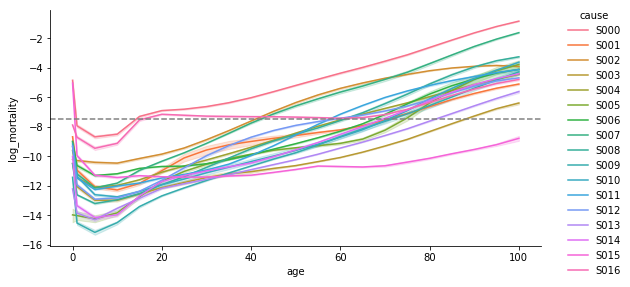

In [4]:
# create the figure
plt.figure(figsize=(14, 8))

# create facetgrid for year and gender
g = sns.FacetGrid(df_long,  hue='cause', height=4, aspect=2, 
                  margin_titles=True)

g.map(sns.lineplot, 'age', 'log_mortality').add_legend()


# Add a horizontal line at y = -7.5
for ax in g.axes.flat:
    ax.axhline(y=-7.5, color="gray", linestyle="--")

In [5]:
def lighten_cmap(cmap_name='winter', factor=0.5):
    """Lighten a given colormap by blending it with white."""
    base = cm.get_cmap(cmap_name)
    colors = base(np.linspace(0, 1, 256))
    white = np.ones((256, 4))  # RGBA for white
    colors = colors * (1 - factor) + white * factor
    return mcolors.ListedColormap(colors)

light_winter = lighten_cmap('winter', factor=0.3)

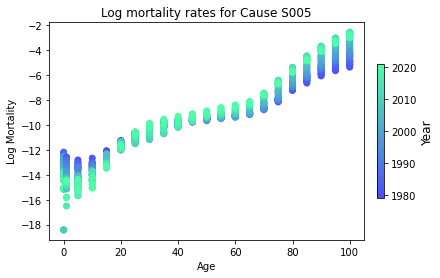

In [6]:
# plot of one specific cause: 
cause = 'S005'
cause_data = df_long[df_long['cause'] == cause]

# Set up the figure and axes
fig, ax = plt.subplots()

# Use 'year' to color the points
scatter = ax.scatter(cause_data['age'], cause_data['log_mortality'], c=cause_data['year'], cmap=light_winter)

# Labels and title
ax.set_xlabel("Age")
ax.set_ylabel("Log Mortality")
ax.set_title(f"Log mortality rates for Cause {cause}")

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Year', fontsize=12)

plt.show()


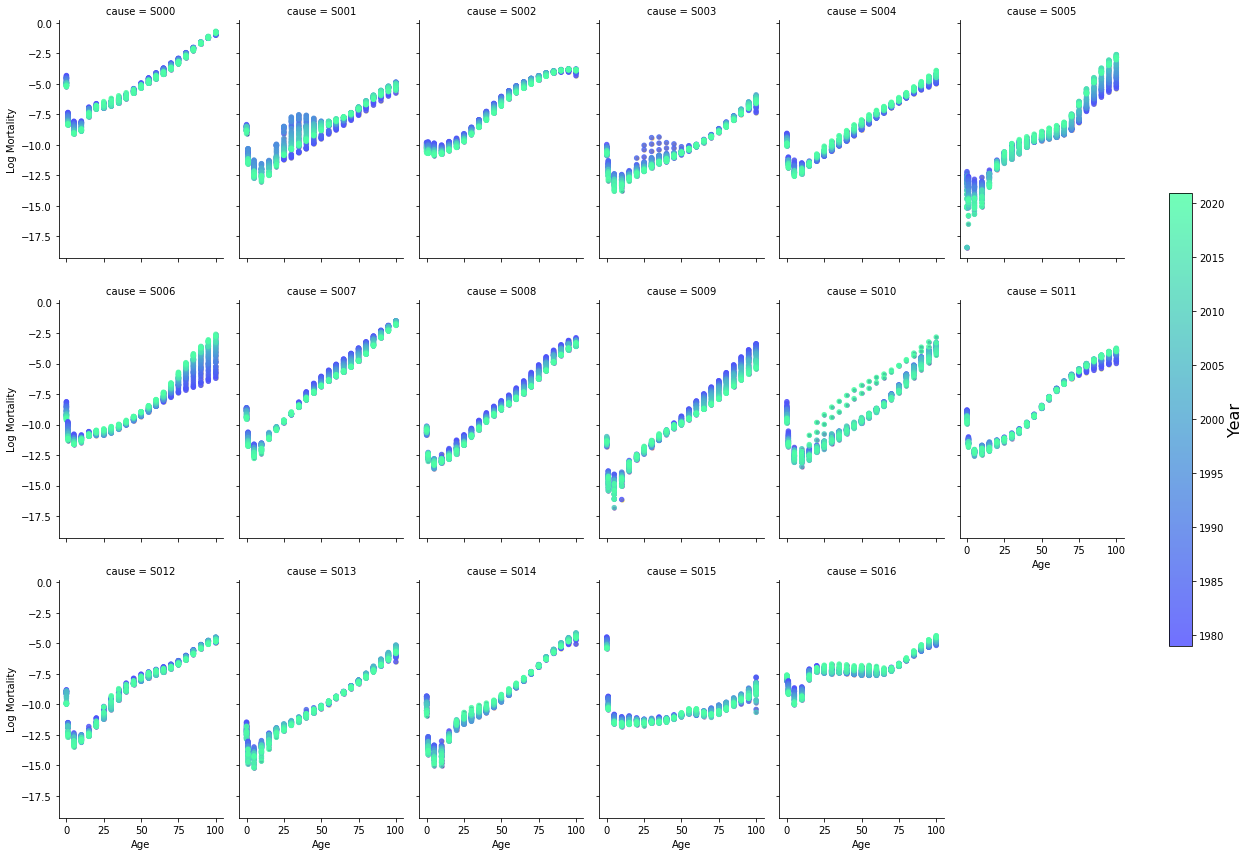

In [7]:
# the time trend of log_mortality by cause
g = sns.FacetGrid(df_long, col='cause', hue='year', palette='plasma_r',
                  margin_titles=True, height=4, aspect=0.7, col_wrap=6)

g.map(sns.scatterplot, 'age', 'log_mortality', s=20)

# Adjust the title, legend, and axis formatting
g.set_axis_labels("Age", "Log Mortality")


for ax, (_, subset) in zip(g.axes.flat, df_long.groupby(['cause'])):
    scatter = ax.scatter(subset['age'], subset['log_mortality'], 
                         c=subset['year'], cmap=light_winter, s=20, alpha=0.8)
    
cbar = g.fig.colorbar(scatter, ax=g.axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Year', fontsize=16)

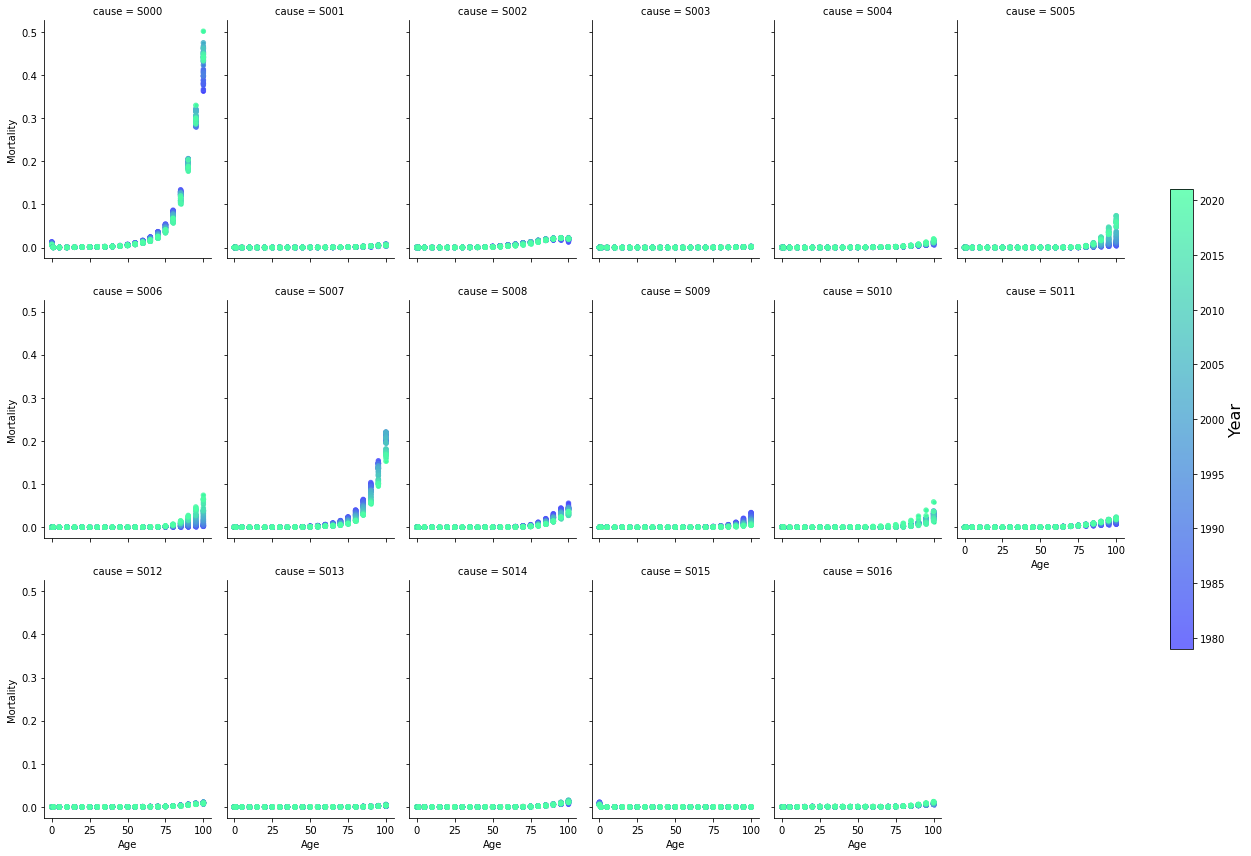

In [8]:
# the time trend of mortality by cause

g = sns.FacetGrid(df_long, col='cause', hue='year', palette='winter',
                  margin_titles=True, height=4, aspect=0.7, col_wrap=6)

g.map(sns.scatterplot, 'age', 'm', s=20)

# Adjust the title, legend, and axis formatting
g.set_axis_labels("Age", "Mortality")


for ax, (_, subset) in zip(g.axes.flat, df_long.groupby(['cause'])):
    scatter = ax.scatter(subset['age'], subset['m'], 
                         c=subset['year'], cmap=light_winter, s=20, alpha=0.8)
    
cbar = g.fig.colorbar(scatter, ax=g.axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Year', fontsize=16)